In [1]:
import random, gc, os, pickle, csv

import datasets.utils
import models.utils
from models.cls_oml_ori_v2 import OML

import matplotlib.pyplot as plt
import numpy as np

import higher
import torch
import torch.nn.functional as F
from torch.utils import data

# Constants

In [2]:
dataset_order_mapping = {
    1: [2, 0, 3, 1, 4],
    2: [3, 4, 0, 1, 2],
    3: [2, 4, 1, 3, 0],
    4: [0, 2, 1, 4, 3]
}
n_classes = 33
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# model_path = "/data/model_runs/original_oml/aOML-order1-2022-07-18/OML-order1-id4-2022-07-18_17-53-13.518612.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr002-2022-07-31/OML-order1-id4-2022-07-31_14-53-46.456804.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr005-2022-07-31/OML-order1-id4-2022-07-31_18-47-41.477968.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr005-up20-2022-08-01/OML-order1-id4-2022-08-01_14-45-55.869765.pt"
model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31/OML-order1-id4-2022-07-31_21-18-36.241546.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr020-2022-08-16/OML-order1-id4-2022-08-16_11-37-19.424113.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr050-2022-08-16/OML-order1-id4-2022-08-16_14-16-12.167637.pt"


# memory_path = "/data/model_runs/original_oml/aOML-order1-2022-07-18/OML-order1-id4-2022-07-18_17-53-13.518639_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr002-2022-07-31/OML-order1-id4-2022-07-31_14-53-46.456828_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr005-2022-07-31/OML-order1-id4-2022-07-31_18-47-41.477992_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr005-up20-2022-08-01/OML-order1-id4-2022-08-01_14-45-55.869797_memory.pickle"
memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31/OML-order1-id4-2022-07-31_21-18-36.241572_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr020-2022-08-16/OML-order1-id4-2022-08-16_11-37-19.424139_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr050-2022-08-16/OML-order1-id4-2022-08-16_14-16-12.167666_memory.pickle"


use_db_cache = True
cache_dir = 'tmp'

In [3]:
args = {
    "order": 1,
    "n_epochs": 1,
    "lr": 3e-5,
    "inner_lr": 0.001*50,
    "meta_lr": 3e-5,
    "model": "bert",
    "learner": "oml",
    "mini_batch_size": 16,
    "updates": 5*2,
    "write_prob": 1.0,
    "max_length": 448,
    "seed": 42,
    "replay_rate": 0.01,
    "replay_every": 9600
}
updates = args["updates"]
mini_batch_size = args["mini_batch_size"]
order = args["order"]

In [4]:
torch.manual_seed(args["seed"])
random.seed(args["seed"])
np.random.seed(args["seed"])

# Load Dataset

In [5]:
print('Loading the datasets')
test_datasets = []
for dataset_id in dataset_order_mapping[order]:
    test_dataset_file = os.path.join(cache_dir, f"{dataset_id}.cache")
    if os.path.exists(test_dataset_file):
        with open(test_dataset_file, 'rb') as f:
            test_dataset = pickle.load(f)
    else:
        test_dataset = datasets.utils.get_dataset_test("", dataset_id)
        print('Loaded {}'.format(test_dataset.__class__.__name__))
        test_dataset = datasets.utils.offset_labels(test_dataset)
        pickle.dump(test_dataset, open( test_dataset_file, "wb" ), protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Pickle saved at {test_dataset_file}")
    test_datasets.append(test_dataset)
print('Finished loading all the datasets')

Loading the datasets
Finished loading all the datasets


# Load Model

In [6]:
learner = OML(device=device, n_classes=n_classes, **args)
print('Using {} as learner'.format(learner.__class__.__name__))
learner.load_model(model_path)
with open(memory_path, 'rb') as f:
    learner.memory = pickle.load(f)

2022-08-23 08:11:53,360 - transformers.tokenization_utils_base - INFO - loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
2022-08-23 08:11:54,610 - transformers.configuration_utils - INFO - loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
2022-08-23 08:11:54,613 - transformers.configuration_utils - INFO - Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer

Using OML as learner


# Testing

Select specific column index per row
https://stackoverflow.com/questions/23435782/numpy-selecting-specific-column-index-per-row-by-using-a-list-of-indexes

In [7]:
def evaluate(dataloader, updates, mini_batch_size):
    learner.rln.eval()
    learner.pln.train()
    
    support_set = []
    for _ in range(updates):
        text, labels = learner.memory.read_batch(batch_size=mini_batch_size)
        support_set.append((text, labels))
        print(labels)
    
#     with higher.innerloop_ctx(learner.pln, learner.inner_optimizer,
#                               copy_initial_weights=False, track_higher_grads=False) as (fpln, diffopt):

#         # Inner loop
#         task_predictions, task_labels = [], []
#         support_loss = []
#         for text, labels in support_set:
#             labels = torch.tensor(labels).to(device)
#             input_dict = learner.rln.encode_text(text)
#             _repr = learner.rln(input_dict)
#             output = fpln(_repr)
#             loss = learner.loss_fn(output, labels)
#             diffopt.step(loss)
#             pred = models.utils.make_prediction(output.detach())
#             support_loss.append(loss.item())
#             task_predictions.extend(pred.tolist())
#             task_labels.extend(labels.tolist())

#         acc, prec, rec, f1 = models.utils.calculate_metrics(task_predictions, task_labels)

#         print('Support set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
#                     'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(support_loss), acc, prec, rec, f1))

#         all_losses, all_predictions, all_labels, all_label_conf = [], [], [], []

#         for text, labels in dataloader:
#             labels = torch.tensor(labels).to(device)
#             input_dict = learner.rln.encode_text(text)
#             with torch.no_grad():
#                 _repr = learner.rln(input_dict)
#                 output = fpln(_repr) # Output has size of torch.Size([16, 33]) [BATCH, CLASSES]
#                 loss = learner.loss_fn(output, labels)
#             loss = loss.item()
#             # print(output.detach().size())
#             # output.detach().max(-1) max on each Batch, which will return [0] max, [1] indices
#             output_softmax = F.softmax(output, -1)
#             label_conf = output_softmax[np.arange(len(output_softmax)), labels] # Select labels in the softmax of 33 classes
            
#             pred = models.utils.make_prediction(output.detach())
            
#             all_losses.append(loss)
#             all_predictions.extend(pred.tolist())
#             all_labels.extend(labels.tolist())
#             all_label_conf.extend(label_conf.tolist())

#     acc, prec, rec, f1 = models.utils.calculate_metrics(all_predictions, all_labels)
#     print('Test metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, recall = {:.4f}, '
#                 'F1 score = {:.4f}'.format(np.mean(all_losses), acc, prec, rec, f1))
    return support_set

In [8]:
print('----------Testing on test set starts here----------')

# Data for Replay Imbalance: Yelp --> [[...text], [...label]]
data_for_replay = {}

for test_dataset in test_datasets:
    print('Testing on {}'.format(test_dataset.__class__.__name__))
    test_dataloader = data.DataLoader(test_dataset, batch_size=mini_batch_size, shuffle=False,
                                      collate_fn=datasets.utils.batch_encode)
    
    support_set = evaluate(dataloader=test_dataloader, updates=updates, mini_batch_size=mini_batch_size)
    
    text_list = [item for s in support_set for item in s[0]]
    label_list = [item for s in support_set for item in s[1]]
    
    data_for_replay[test_dataset.__class__.__name__] = [text_list, label_list]
print("DONE")

----------Testing on test set starts here----------
Testing on YelpDataset
[6, 0, 14, 22, 15, 8, 0, 24, 1, 1, 0, 0, 3, 6, 11, 25]
[4, 8, 31, 3, 22, 29, 15, 0, 7, 4, 4, 12, 6, 7, 3, 3]
[3, 1, 4, 0, 1, 21, 4, 23, 31, 8, 1, 0, 19, 2, 6, 3]
[1, 9, 9, 4, 22, 4, 0, 17, 26, 3, 7, 4, 1, 6, 9, 0]
[6, 27, 15, 5, 27, 4, 20, 17, 16, 4, 14, 0, 19, 3, 21, 3]
[7, 11, 8, 26, 3, 23, 8, 12, 8, 9, 32, 15, 3, 2, 1, 6]
[5, 26, 27, 4, 3, 0, 5, 5, 0, 1, 1, 4, 23, 27, 21, 0]
[8, 24, 19, 2, 8, 22, 0, 7, 26, 3, 16, 32, 5, 26, 1, 9]
[29, 5, 7, 0, 5, 32, 27, 4, 10, 27, 0, 7, 3, 12, 19, 3]
[9, 3, 3, 32, 2, 24, 7, 7, 27, 6, 12, 30, 2, 8, 25, 7]
Testing on AGNewsDataset
[16, 2, 1, 0, 28, 27, 8, 16, 14, 3, 4, 2, 9, 21, 0, 4]
[1, 12, 4, 2, 4, 0, 24, 12, 21, 30, 6, 29, 8, 30, 22, 25]
[1, 7, 3, 0, 2, 1, 3, 4, 26, 1, 4, 4, 1, 3, 3, 18]
[5, 8, 31, 31, 8, 3, 7, 12, 25, 12, 2, 23, 1, 2, 29, 0]
[2, 20, 8, 2, 32, 30, 5, 1, 3, 6, 3, 2, 1, 10, 25, 11]
[1, 24, 8, 8, 19, 8, 3, 23, 1, 11, 3, 2, 31, 24, 30, 7]
[3, 28, 2, 7, 0, 4, 1

In [9]:
# _model_path0 = os.path.splitext(model_path)[0]
# csv_filename = _model_path0 + "_update"+ str(updates) +"_results.csv"
# with open(csv_filename, 'w') as csv_file:
#     csv_writer = csv.writer(csv_file)
#     csv_writer.writerow(["data_idx", "label", "label_conf", "pred"])
#     csv_writer.writerows(data_for_visual)
# print(f"Done writing CSV File at {csv_filename}")

In [10]:
data_for_replay.keys()

dict_keys(['YelpDataset', 'AGNewsDataset', 'DBPediaDataset', 'AmazonDataset', 'YahooAnswersDataset'])

In [11]:
len(data_for_replay['YelpDataset'][1])

160

In [12]:
count_bins = {}
for label_id in data_for_replay['YelpDataset'][1]:
    if label_id in count_bins:
        count_bins[label_id] += 1
    else:
        count_bins[label_id] = 1
for label_id in range(33):
    if label_id not in count_bins:
        count_bins[label_id] = 0 

In [13]:
def getColorFromIndex(n):
    colorList = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', \
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    return colorList[n%len(colorList)]

In [14]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


(array([16., 11.,  5., 17., 13.,  7.,  8., 10.,  9.,  6.,  1.,  2.,  4.,
         0.,  2.,  4.,  2.,  2.,  0.,  4.,  1.,  3.,  4.,  3.,  3.,  2.,
         5.,  7.,  0.,  2.,  1.,  2.,  4.]),
 array([ 0.        ,  0.96969697,  1.93939394,  2.90909091,  3.87878788,
         4.84848485,  5.81818182,  6.78787879,  7.75757576,  8.72727273,
         9.6969697 , 10.66666667, 11.63636364, 12.60606061, 13.57575758,
        14.54545455, 15.51515152, 16.48484848, 17.45454545, 18.42424242,
        19.39393939, 20.36363636, 21.33333333, 22.3030303 , 23.27272727,
        24.24242424, 25.21212121, 26.18181818, 27.15151515, 28.12121212,
        29.09090909, 30.06060606, 31.03030303, 32.        ]),
 <BarContainer object of 33 artists>)

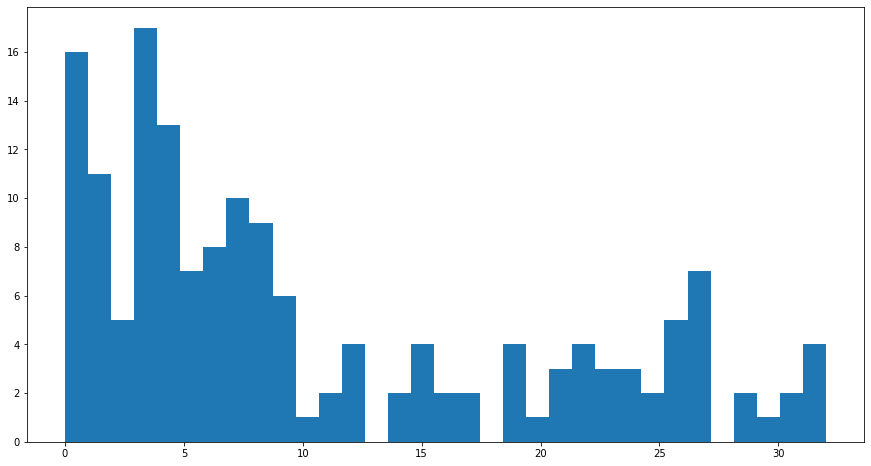

In [15]:
fig, ax =  plt.subplots(figsize=(15,8))
ax.hist(data_for_replay['YelpDataset'][1], bins=33)

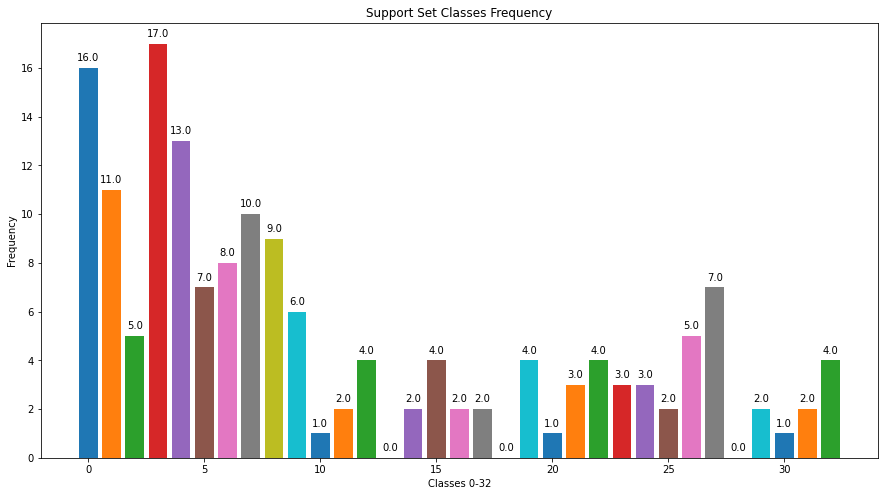

In [16]:
fig, ax =  plt.subplots(figsize=(15,8))
ax.bar(np.arange(33), [count_bins[label_id] for label_id in range(33)], color=[getColorFromIndex(i) for i in range(33)])
# ax.xaxis.set_ticklabels(np.arange(33))

ax.set_title('Support Set Classes Frequency')
ax.set_xlabel('Classes 0-32')
ax.set_ylabel('Frequency')
add_value_labels(ax)

(array([62., 34., 35., 29.]),
 array([ 0,  5,  9, 23, 33]),
 <BarContainer object of 4 artists>)

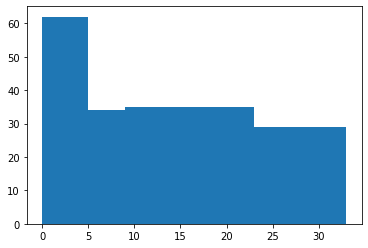

In [17]:
# Amazon/Yelp: 0 (0-4) Length: 5 range(5)
# AgNews: 5 (5-8) Length: 4 range(5, 9)
# DBPedia: 9 (9-22) Length: 14 range(9, 23)
# Yahoo: 23 (23-32) Length: 10 range(23, 33)

plt.hist(data_for_replay['YelpDataset'][1], bins=[0,5, 9,23,33])